In [269]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

In [270]:
train_data = pd.read_csv('data/train.csv', low_memory=False)

In [271]:
def print_cols(df):
    """
    Utility function for printing columns in dataframes
    """
    for col in df.columns:
        print(col)

def print_col_dtypes(df):
    """
    Utility function for printing datatypes in dataframes
    """
    for col in df.columns:
        print(f"{col}: {df[col].dtype}")

In [272]:
from IPython.core.debugger import Pdb as CorePdb
import sys

def breakpoint(condition=True):
    """
    Set a breakpoint at the location the function is called if `condition == True`.

    For example»»»
    def add(a, b):
        breakpoint(type(a) != type(b))

    *Function pulled from StackOverflow
    """
    if condition:
        debugger = CorePdb()
        frame = sys._getframe()
        debugger.set_trace(frame.f_back)
        return debugger

In [273]:
# Constants - evaluated during cross-validation
DEG_M = 111120 # conversion from degrees to meters
BIN_SIZE = 1000 # size of geographic bins in meters
NOMINAL_PRICE = 10001 # sale price below which transaction is considered "not arms length"
OUTLIERS = 10 # percent of outliers at the top and the bottom to drop when analyzing results

In [274]:
# Building Category Codes
RESIDENTIAL = 1
APARTMENTS = 2
STORE_WITH_APT = 3
COMMERCIAL = 4
INDUSTRIAL = 5
VACANT_LAND = 6

In [275]:
# Flags for different column setups
# Evaluated during cross-validation
INCLUDE_JOINED = False
INCLUDE_EXTRA_OPA = True

In [276]:
# columns to keep or drop
# OPA cols were specifically referenced in OPA methodology
OPA_COLS = ['geographic_ward', # best proxy for GMA actually used
            'category_code', # property style
            # missing building square footage
            'year_built',
            'year_built_estimate',
            'total_area',
            'garage_spaces',
            'garage_type',
            'off_street_open', # off street parking spaces
            'interior_condition',
            'central_air',
            'view_type', # view amenity
            # missing proximity to amenities
            # use townhall distance as a proxy
            'market_value', # dependent variable
            # model is attempting to model sale price
            'sale_date',
            'sale_price']
LAT_LNG_COLS = ['lat','lng']

# additional columns that seem plausibly likely to impact assessment value
ADDTL_OPA_COLS = ['exterior_condition',
                'fireplaces',
                'fuel',
                'general_construction',
                'number_of_bathrooms',
                'number_of_bedrooms',
                'number_of_rooms',
                'number_stories',
                'other_building',
                'quality_grade',
                'sewer',
                'site_type',
                'topography',
                'type_heater',
                'unfinished',
                'utility',
                'zoning']

ES_COLS = ['ES_ES_Short','ES_ES_ID','ES_ES_Name']
TOWNHALL_COLS = ['townhallfeet']
PARK_COLS = ['nearpark_distance','nearpark_area','nearpark_type']
JOINED_COLS = ES_COLS + TOWNHALL_COLS + PARK_COLS


### Data Cleaning Pipeline

In [277]:
def set_index(df):
    """
    Set the index to the parcel ID number
    """
    return df.set_index('objectid')

In [278]:
def misc_cleaning(df):
    """
    Handle miscellaneous issues in OPA data
    """
    # latitude and longitude are flipped
    df = df.rename(columns={"lat":"lng","lng":"lat"})
    # convert central air to Y/N
    df.central_air = df.central_air.replace({'0': 'N', '1': 'Y'})
    # convert year built estimante to Y/N
    df.year_built_estimate = df.year_built_estimate.replace({'0': 'N'})
    # convert 0 in interior condition to NaN
    df.interior_condition = df.interior_condition.replace({'0': np.NaN, 0: np.NaN})
    return df

In [279]:
def convert_cat_cols(df):
    """
    Convert categorical columns into 'category' datatype
    """
    cat_cols = ['geographic_ward','category_code','interior_condition']
    added_cat_cols = ['ES_ES_ID', 'fireplaces', 'exterior_condition']
    cat_cols += added_cat_cols
    df[cat_cols] = df[cat_cols].astype('Int64').astype('category')
    return df

In [280]:
def keep_opa_cols(df):
    """
    Keep only the columns specified in the constants at the beginning of the notebook.
    """
    keep_cols = OPA_COLS + LAT_LNG_COLS + ADDTL_OPA_COLS + JOINED_COLS
    return df[keep_cols]

In [281]:
def clean_nan(df):
    """
    Replace NaN values or drop rows with NaN in key columns
    """
    # handle continuous cols
    continuous_cols = ["sale_price","market_value","total_area"]
    df[continuous_cols] = df[continuous_cols].replace({'0':np.nan, 0:np.nan})
    not_na_cols = ['total_area','lat','lng','geographic_ward']
    df = df[df[not_na_cols].notnull().all(axis=1)]
    df = df[df.total_area.notna()]

    return df


In [282]:
def sale_date_adjustment(df):
    """
    OPA does an adjustment on sale price based upon market conditions at the time
    Couldn't find the methodology, so drop for column.
    """
    return df.drop('sale_date',axis=1)

In [283]:
def clean_garages(df):
    """
    Standardize garage_type data to all be in the same format
    """
    df.loc[df.garage_type == '0.0','garage_type'] = '0' 
    df.loc[df.garage_type == '1.0','garage_type'] = '1' 
    df.loc[df.garage_type == '2.0','garage_type'] = '2'
    df.loc[df.garage_type == '3.0','garage_type'] = '3'
    
    return df    

In [284]:
def bucket_garage_spaces(df):
    """
    Bucket garage spaces into categories
    """
    conditions = [df.garage_spaces == 1,
                  df.garage_spaces == 2,
                  df.garage_spaces == 3,
                  df.garage_spaces == 4,
                  df.garage_spaces == 5,
                  df.garage_spaces.gt(5) & df.garage_spaces.lt(10),
                  df.garage_spaces.ge(10) & df.garage_spaces.lt(20),
                  df.garage_spaces.ge(20) & df.garage_spaces.lt(30),
                  df.garage_spaces.ge(30) & df.garage_spaces.lt(40),
                  df.garage_spaces.ge(40)]
    
    choices = ['1','2','3','4','5','6-10','10-20','20-30','30-40','40+']
    
    df['garage_space_cats'] = np.select(conditions,choices,'0')
    df = df.drop('garage_spaces',axis=1)
    
    return df

In [285]:
def bucket_street_spaces(df):
    """
    Bucket street spaces into categories
    """
    conditions = [df.off_street_open == 0,
              df.off_street_open == 1,
              df.off_street_open == 2,
              df.off_street_open == 3,
              df.off_street_open == 4,
              df.off_street_open == 5,
              df.off_street_open.gt(5) & df.off_street_open.lt(10),
              df.off_street_open.ge(10) & df.off_street_open.lt(20),
              df.off_street_open.ge(20) & df.off_street_open.lt(30),
              df.off_street_open.ge(30) & df.off_street_open.lt(40),
              df.off_street_open.ge(40)]
    
    choices = ['0','1','2','3','4','5','6-10','10-20','20-30','40-50','50+']
    
    df['off_street_open_cats'] = np.select(conditions,choices)
    df = df.drop('off_street_open',axis=1)
    
    return df

In [286]:
def bucket_year_built(df):
    """
    Bucket year-built data into categories
    """
    # handle incorrectly entered values
    df.loc[df['year_built'] == '196Y', 'year_built'] = 1960
    df.loc[df['year_built'] == '9150', 'year_built'] = 1950

    # assume 0 and NaN values are the same
    df.year_built = df.year_built.astype('float').fillna(0).astype('int64')
    
    # bucket year built values
    conditions = [df.year_built.isna(),
                    df.year_built.lt(1700),
                  df.year_built.ge(1700) & df.year_built.lt(1800),
                  df.year_built.ge(1800) & df.year_built.lt(1900),
                  df.year_built.ge(1900) & df.year_built.lt(1910),
                  df.year_built.ge(1910) & df.year_built.lt(1920),
                  df.year_built.ge(1920) & df.year_built.lt(1930),
                  df.year_built.ge(1930) & df.year_built.lt(1940),
                  df.year_built.ge(1940) & df.year_built.lt(1950),
                  df.year_built.ge(1950) & df.year_built.lt(1960),
                  df.year_built.ge(1960) & df.year_built.lt(1970),
                  df.year_built.ge(1970) & df.year_built.lt(1980),
                  df.year_built.ge(1980) & df.year_built.lt(1990),
                  df.year_built.ge(1990) & df.year_built.lt(2000),
                  df.year_built.ge(2000) & df.year_built.lt(2010),
                  df.year_built.ge(2010) & df.year_built.lt(2020),
                  df.year_built.ge(2020)]
    
    
    choices = [np.NaN,'Pre_1700','1700s','1800s','1900s','1910s','1920s','1930s','1940s','1950s','1960s','1970s','1980s','1990s','2000s','2010s','2020s']
    
    df['year_category'] = np.select(conditions,choices)
    
    year_cols = ['year_built']
    df = df.drop(year_cols, axis=1)
    return df

In [287]:
def bucket_building_characteristics(df):
    """
    Bucket various building characteristics into categories
    """
    # number of bathrooms
    conditions = [df.number_of_bathrooms == 0,
                    df.number_of_bathrooms == 1,
                    df.number_of_bathrooms == 2,
                    df.number_of_bathrooms == 3,
                    df.number_of_bathrooms == 4,
                    df.number_of_bathrooms == 5,
                    df.number_of_bathrooms == 6,
                    df.number_of_bathrooms.ge(7)]
    choices = ['0','1','2','3','4','5','6','7+']
    df['bathrooms_category'] = np.select(conditions,choices)

    # number of bedrooms
    conditions = [df.number_of_bedrooms == 0,
                    df.number_of_bedrooms == 1,
                    df.number_of_bedrooms == 2,
                    df.number_of_bedrooms == 3,
                    df.number_of_bedrooms == 4,
                    df.number_of_bedrooms == 5,
                    df.number_of_bedrooms == 6,
                    df.number_of_bedrooms.ge(7)]
    choices = ['0','1','2','3','4','5','6','7+']
    df['bedrooms_category'] = np.select(conditions,choices)

    # number of rooms
    conditions = [df.number_of_rooms == 0,
                    df.number_of_rooms == 1,
                    df.number_of_rooms == 2,
                    df.number_of_rooms == 3,
                    df.number_of_rooms == 4,
                    df.number_of_rooms == 5,
                    df.number_of_rooms == 6,
                    df.number_of_rooms == 7,
                    df.number_of_rooms == 8,
                    df.number_of_rooms == 9,
                    df.number_of_rooms == 10,
                    df.number_of_rooms == 11,
                    df.number_of_rooms == 12,
                    df.number_of_rooms.ge(13),
                    ]
    choices = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13+']
    df['rooms_category'] = np.select(conditions,choices)

    # number of stories
    conditions = [df.number_stories == 0,
                    df.number_stories == 1,
                    df.number_stories == 2,
                    df.number_stories == 3,
                    df.number_stories == 4,
                    df.number_stories == 5,
                    df.number_stories == 6,
                    df.number_stories.ge(7) & df.number_stories.le(10),
                    df.number_stories.ge(11) & df.number_stories.le(15),
                    df.number_stories.ge(16) & df.number_stories.le(20),
                    df.number_stories.ge(21) & df.number_stories.le(25),
                    df.number_of_rooms.ge(26),
                    ]
    choices = ['0','1','2','3','4','5','6','7-10','11-15','16-20','21-25','26+']
    df['stories_category'] = np.select(conditions,choices)

    building_cols = ['number_of_bathrooms', 'number_of_bedrooms', 'number_of_rooms', 'number_stories']
    df = df.drop(building_cols, axis=1)

    return df
    

In [288]:
def remove_joined_cols(df):
    """
    Optional function that removes the additional joined columns. Activated based on the flags defined in the constants section at the top of the notebook.
    """
    return df.drop(JOINED_COLS, axis=1)

In [289]:
def remove_addtl_opa_cols(df):
    """
    Optional function that removes the additional columns from the OPA data. Activated based on the flags defined in the constants section at the top of the notebook.
    """
    return df.drop(ADDTL_OPA_COLS, axis=1)

In [290]:
def get_dummies(df):
    """
    Do one hot encoding for categorical variables
    """
    no_dummies = ['geographic_ward','category_code']
    df_dummies = pd.get_dummies(df.drop(no_dummies,axis=1), dummy_na=True)
    df_cat = df[no_dummies]
    return pd.concat((df_cat, df_dummies), axis=1)

In [291]:
def get_target_per_ft(df):
    """
    Convert target columns to "price per square foot"
    """
    df['sale_price_per_ft'] = df.sale_price/df.total_area
    df['market_price_per_ft'] = df.market_value/df.total_area
    return df

In [292]:
def drop_nominal(df):
    """
    Drop transactions below some threshold. Threshold is defined in the constants at the top of the notebook.
    """
    df.loc[(df.sale_price < NOMINAL_PRICE), 'sale_price'] = np.NaN
    return df

In [293]:
def cleaning_pipeline(df):
    """
    Full data cleaning pipeline.

    Parameters
    ----------
    df: DataFrame
        Dataframe read from OPA data file

    Returns
    -------
    df: DataFrame
        Cleaned frame
    """
    df = set_index(df)
    df = misc_cleaning(df)
    df = convert_cat_cols(df)
    df = keep_opa_cols(df)
    df = clean_nan(df)
    df = bucket_garage_spaces(df)
    df = bucket_street_spaces(df)
    df = bucket_year_built(df)
    if INCLUDE_EXTRA_OPA:
        df = bucket_building_characteristics(df)
    df = sale_date_adjustment(df)
    df = clean_garages(df)
    if not INCLUDE_JOINED:
        df = remove_joined_cols(df)
    if not INCLUDE_EXTRA_OPA:
        df = remove_addtl_opa_cols(df)
    df = get_dummies(df)
    df = get_target_per_ft(df)
    df = drop_nominal(df)
    return df

In [294]:
def create_geographic_bins(df):
    """
    Create geographic bins based upon size defined by BIN_SIZE.

    Add information on geographic bin to each example in df

    Parameters
    ----------
    df: DataFrame
        Cleaned dataframe

    Returns
    -------
    df: DataFrame
        Dataframe with geographic bin information added in columns 'lat_bin', 'lng_bin', and 'lat_lng_bin'. Also includes the average vacant land sale price in each example's geographic bin in 'avg_sale_price_per_ft'
    df_avg: DataFrame
        Dataframe with each geographic bin as rows. The most important column is 'avg_sale_price_per_ft_log' which includes the average sale price of all vacant land in the bin.
    """
    # "more negative" longitudes are further west
    # "more positive" latitudes are further north
    south = df.lat.min()
    north = df.lat.max()
    east = df.lng.max()
    west = df.lng.min()

    southwest = south, west
    southeast = south, east
    northwest = north, west
    northeast = north, east
    
    east_west_deg = abs(west - east)
    north_south_deg = abs(north-south)
    
    # sort into bins
    bin_size = BIN_SIZE/DEG_M # bin size in degrees

    df['lat_bin'] = (((df.lat-south))//bin_size).astype('int')
    df['lng_bin'] = (((df.lng-west))//bin_size).astype('int')
    df['lat_lng_bin'] = list(zip(df.lat_bin, df.lng_bin))
    
    bin_avg = {}
    center_bin_lat = {}
    center_bin_lng = {}
    sw_bin_lat = {}
    sw_bin_lng = {}
    nw_bin_lat = {}
    nw_bin_lng = {}
    se_bin_lat = {}
    se_bin_lng = {}
    ne_bin_lat = {}
    ne_bin_lng = {}
    x_bin = {}
    y_bin = {}


    for i, bin in enumerate(df.lat_lng_bin.unique()):
        # average all sale prices per square foot within given bin
        # use strings of the bins as index to avoid indexing errors later trying to use tuples
        bin_avg[str(bin)] = df[(df.lat_lng_bin == bin) & (df.category_code == VACANT_LAND)].sale_price_per_ft.mean()

        # bin coordinate is the location at the center of the bin
        center_bin_lat[str(bin)] = bin[0]*bin_size + .5*bin_size + south
        center_bin_lng[str(bin)] = bin[1]*bin_size + .5*bin_size + west
        sw_bin_lat[str(bin)] = bin[0]*bin_size + south
        sw_bin_lng[str(bin)] = bin[1]*bin_size + west
        nw_bin_lat[str(bin)] = bin[0]*(bin_size+1) + south
        nw_bin_lng[str(bin)] = bin[1]*bin_size + west
        se_bin_lat[str(bin)] = bin[0]*bin_size + south
        se_bin_lng[str(bin)] = bin[1]*(bin_size+1) + west
        ne_bin_lat[str(bin)] = bin[0]*(bin_size+1) + south
        ne_bin_lng[str(bin)] = bin[1]*(bin_size+1) + west
        x_bin[str(bin)] = int(bin[0])
        y_bin[str(bin)] = int(bin[1])

        # if i%10 == 0:
        #     print(f"Bin #: {bin}")
        
    bin_cols = [center_bin_lat,center_bin_lng,sw_bin_lat,sw_bin_lng,nw_bin_lat,nw_bin_lng,se_bin_lat,se_bin_lng,ne_bin_lat,ne_bin_lng,x_bin,y_bin,bin_avg]
        
    df_avg = pd.DataFrame(bin_cols).transpose().rename(columns={
    0: "center_lat", 
    1: "center_lng",
    2: "sw_lat", 
    3: "sw_lng", 
    4: "nw_lat", 
    5: "nw_lng",
    6: "se_lat", 
    7: "se_lng",
    8: "ne_lat", 
    9: "ne_lng",
    10: "x_bin",
    11: "y_bin",
    12: "avg_sale_price_per_ft"})
    
    df_avg['avg_sale_price_per_ft_log'] = np.log(df_avg.avg_sale_price_per_ft)
    
    sale_price_dict = df_avg.avg_sale_price_per_ft.to_dict()
    df['avg_sale_price_per_ft'] = df.lat_lng_bin.map(str).map(sale_price_dict)
    
    return df, df_avg
    

In [295]:
def log_df(df):
    """
    Take the natural log of all continuous variables in the dataframe and replace columns with <column name>_log

    Parameters
    ----------
    df: DataFrame
        Cleaned dataframe

    Returns
    -------
    df_log: DataFrame
        Dataframe with all continuous columns (other than latitude and longitude) logged and replaced with <column name>_log
    """
    df_log = df.copy()
    dont_log = ['lat','lng']
    logged_cols = []

    if INCLUDE_JOINED:
        # replace zeros in joined columns with nan
        no_zeros = ['townhallfeet', 'nearpark_area', 'nearpark_distance']
        df[no_zeros] = df[no_zeros].replace({'0':np.nan, 0:np.nan})
    
    for col in df.columns:
        if df_log[col].dtype == 'float64' and col not in dont_log:
            logged_cols.append(col)
            df_log[col + "_log"] = np.log(df[col]) 

    if INCLUDE_JOINED:
        # put 0s back in
        zeros = ['townhallfeet_log', 'nearpark_area_log', 'nearpark_distance_log']
        df_log[zeros] = df_log[zeros].fillna(0)


    return df_log.drop(logged_cols, axis=1)

In [296]:
# for using a fraction of the dataframe for faster runtimes
# stabilizes between .1-.2 (50,000-100,000 examples)
FRAC = 1
df = train_data.sample(frac=FRAC, random_state=1)

In [297]:
df = cleaning_pipeline(df)

In [298]:
df, df_avg = create_geographic_bins(df)

In [299]:
df_log = log_df(df)

### Calculate Kernel

In [300]:
# bandwidths is the "distance (in units of bins) to consider when creating the weighted average"
BANDWIDTHS = [1, 2, 3, 4, 5, 10, 15, 20, 30, 40, 60, 80, 100]

In [301]:
def get_kernel_estimator(df_avg, lam=29, bandwidths=BANDWIDTHS):
    """
    Iteratively estimate the log land price per ft in each geographic bin.

    Start with an initial estimate based upon the average land value in each bin.

    Then, increase the number of bins considered by using BANDWIDTHS. Land value estimator is the Nadaraya-Watson estimator and is updated by taking a weighted average of other bins by using a distance kernel and a leveling kernel. Both distance and leveling kernels use the Epanechnikov kernel function. This weights values that are geographically closer and closer in value more highly.

    This function iterates through each bandwidth and uses the land value estimator from the previous loop while calculating the kernels.

    Parameters
    ----------
    df_avg: DataFrame
        Dataframe containing the average vacant land values in each geographic bin. Produced by the create_geographic_bins function.

    lam: int
        Bandwidth for the leveling kernel. Used to decide how "close" land value estimates must be in order to effect each other. Chosen through experimentation.

    bandwidths: list[int]
        Distance (in number of geographic bins) to consider on each iteration of the kernel estimation process. Used as input into the distance kernel function

    Returns
    -------
    estimator_dict: dictionary
        Dictionary that includes the final land value estimate for each geographic bin.
    """
    # kernel initialization - used as the baseline for the kernel iteration loop in the following loop
    kernels_dict = {}
    i = 0
    for idx, x in df_avg.iterrows():
        kernel_init = np.zeros(len(df_avg))
        kernel_init[i] = x.avg_sale_price_per_ft_log
        kernels_dict[idx] = kernel_init
        i += 1
    kernels = pd.DataFrame(kernels_dict,index=kernels_dict.keys())
    kernels['total'] = kernels.sum(axis=1)
    kernels['center_lat'] = df_avg.center_lat
    kernels['center_lng'] = df_avg.center_lng
    kernels['x_bin'] = df_avg.x_bin
    kernels['y_bin'] = df_avg.y_bin
    kernels['estimator'] = df_avg.avg_sale_price_per_ft_log
    kernels['number_of_bins'] = kernels.estimator.notnull().astype('int')

    for i, h in enumerate(bandwidths):
        print(f"iter: {i}")
        avgs = []
        bins = []
            
        for idx, x in kernels.iterrows():      
            # calculate K1
            distance = (abs(df_avg.x_bin - x.x_bin) + abs(df_avg.y_bin - x.y_bin))/h
            indicator_k1 = distance <= 1

            # use Epanechnikov kernel for k1
            k1 = indicator_k1*3/4*(1-(distance ** 2))

            # calculate K2
            if i == 0:
                level = np.zeros(len(kernels)) # just set the the level equal to 0 for the 1st iteration
            else:
                sig = kernels.estimator.std()
                sig_term = (2*(sig**2))**.5
                level = (x.number_of_bins/lam)*((kernels.estimator - x.estimator)/sig_term)**2 # need to multiply by the number of bins used for the estimator in the previous iteration
            indicator_k2 = level <= 1

            # use Epanechnikov kernel
            k2 = indicator_k2*3/4*(1-(level ** 2))
            k2 = indicator_k2*(1-(level ** 2))
            
            k1k2 = k1 * k2
            no_bins = np.logical_and(indicator_k1,indicator_k2).sum()
            
            w_avg_vec = (k1k2/k1k2.sum() * df_avg.avg_sale_price_per_ft_log)
            w_avg = w_avg_vec.sum()
            avgs.append(w_avg)
            bins.append(no_bins)
            # breakpoint(w_avg > 10)
            
            # make new kernels dataframe from current estimates
            kernels_dict[idx] = k1k2
            
        # print(f"min: {kernels.estimator.min()}")
        # print(f"max: {kernels.estimator.max()}")
        kernels = pd.DataFrame(kernels_dict)
        kernels['total'] = kernels.sum(axis=1)
        kernels['center_lat'] = df_avg.center_lat
        kernels['center_lng'] = df_avg.center_lng
        kernels['x_bin'] = df_avg.x_bin
        kernels['y_bin'] = df_avg.y_bin
        kernels['estimator'] = avgs
        kernels['number_of_bins'] = bins

    estimator_dict = kernels.estimator.to_dict()
    return estimator_dict

In [302]:
estimator_dict = get_kernel_estimator(df_avg)
# look up the kernel estimator by lat_lng_bin in dictionary returned by get_kernel_estimator and add that to each row of the dataframe
df_log['kernel_land_price_per_ft_log'] = df_log.lat_lng_bin.map(str).map(estimator_dict)

iter: 0
iter: 1
iter: 2
iter: 3
iter: 4
iter: 5
iter: 6
iter: 7
iter: 8
iter: 9
iter: 10
iter: 11
iter: 12


In [304]:
print(np.max(list(estimator_dict.values())))
print(np.min(list(estimator_dict.values())))
print(np.mean(list(estimator_dict.values())))
print(np.median(list(estimator_dict.values())))

5.451331306017134
-13.263029486613048
1.6559724063699985
2.2547903952157125


In [305]:
print(df_avg.avg_sale_price_per_ft_log.max()) 
print(df_avg.avg_sale_price_per_ft_log.min())
print(df_avg.avg_sale_price_per_ft_log.mean())
print(np.median(df_avg.avg_sale_price_per_ft_log.notna()))

8.336705572220088
-14.858633392245666
1.8283315057888778
1.0


#### Some Plots

In [87]:
fig = px.scatter_mapbox(df_log[df.category_code == 6].sample(frac=.1), 
                        lat="lat", 
                        lon="lng",
                        color="sale_price_per_ft_log",
                       )

fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        # 'center': {'lon': -75.16, 'lat': 39.95},
        'style': "stamen-terrain",
        'zoom': 11,
    },
)

fig.show()

In [38]:
fig.write_image("vacant-lot-sales.png")

In [39]:
fig = px.scatter_mapbox(df_log.sample(frac=.1), 
                        lat="lat", 
                        lon="lng",
                        color="avg_sale_price_per_ft_log",
                       )

fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        # 'center': {'lon': -75.16, 'lat': 39.95},
        'style': "stamen-terrain",
        'zoom': 11,
    },
)

fig.show()

In [40]:
fig.write_image("average-lot-sale.png")

In [105]:
fig = px.scatter_mapbox(df_log.sample(frac=.1), 
                        lat="lat", 
                        lon="lng",
                        color="kernel_land_price_per_ft_log",
                       )

fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        # 'center': {'lon': -75.16, 'lat': 39.95},
        'style': "stamen-terrain",
        'zoom': 11,
    },
)

fig.show()

#### Get X,y Split for Sale Price and Market Value

In [306]:
def drop_extra_cols(df):
    """
    Drop columns not used in regression
    """
    extra_cols = ['lat','lng','geographic_ward', 'category_code', 'lat_bin', 'lng_bin', 'lat_lng_bin', 'avg_sale_price_per_ft_log']
    return df.drop(extra_cols, axis=1)

In [307]:
def sale_xy(df):
    """
    Split dataframe into X and y with sale price as the target

    Parameters
    ----------
    df: DataFrame
        Fully cleaned and logged dataframe with all column manipulation complete

    Returns
    -------
    X: DataFrame
        Dataframe with examples to use in regression

    y: Series
        Target value (log of the sale price per foot)
    """
    df = drop_extra_cols(df)
    df = df[df.sale_price_log.notna()]
    
    # target_cols = ['market_value', 'sale_price', 'sale_price_per_ft']
    target_cols_log = ['market_value_log', 'sale_price_log', 'sale_price_per_ft_log', 'market_price_per_ft_log']
    y = df['sale_price_per_ft_log']
    X = df.drop(target_cols_log, axis=1)
    
    return X, y

In [308]:
# use only residential data for predictions
X, y = sale_xy(df_log[df_log.category_code == RESIDENTIAL])

#### Feature Selection

In [309]:
# use XGBoost to select the most important columns
import xgboost as xgb

lr = .1
max_depth = 8
n_estimators = 180

model_xgb_fit = xgb.XGBRegressor(learning_rate=lr,max_depth=max_depth,n_estimators=n_estimators)

In [310]:
model_xgb_fit.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=180, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [356]:
FEATURES_TO_SELECT = len(X.columns) // 2
important = model_xgb_fit.feature_importances_.argsort()[-FEATURES_TO_SELECT:]
selected_features = X.columns[important]

In [357]:
# define XX to only include the selected features
XX = X[selected_features]

Text(0.5, 0, 'Xgboost Feature Importance')

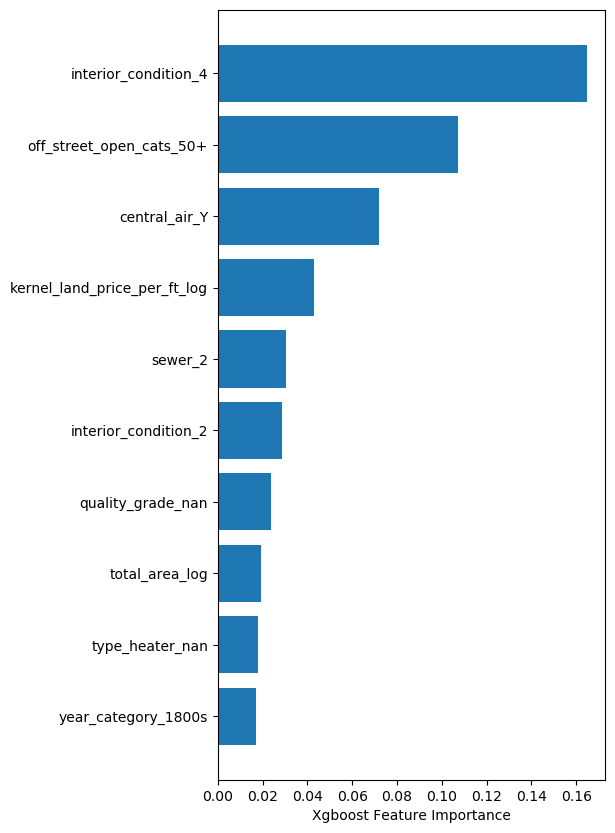

In [358]:
from matplotlib import pyplot as plt

sorted_idx = model_xgb_fit.feature_importances_.argsort()
plt.rcParams["figure.figsize"] = (5,10)
plt.barh(X.columns[important][-10:], model_xgb_fit.feature_importances_[important][-10:])
plt.xlabel("Xgboost Feature Importance")

### Fit Different Models

#### Model Evaluation Code

In [314]:
from sklearn.model_selection import RepeatedKFold
rkf = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)

In [315]:
def assessment_to_sale(y, yhat):
    """
    Get the ratio of predicted sale price to actual sale price

    Parameters
    ----------
    y: Series
        Actual sale price (as log sale price per square foot)
    
    yhat: Series
        Predicted sale price (as log sale price per square foot)

    Returns
    -------
    ratio: Series
        Ratio of predicted sale price to actual sale price
    """
    return np.exp(yhat)/np.exp(y)

In [316]:
def coefficient_of_dispersion(ratio):
    """
    The coefficient of dispersion is a real estate specific measure of the variation in assessed price to actual price. Goal value is less than 15% for jurisdictions like Philadelphia.

    This can be thought of as "the average amount by which the ratio of assessed to actual sale value differs from the median ratio of assessed to actual sale value"

    Parameters
    ----------
    ratio: list[float]
        Assessed to actual sale price for each property in the sample

    Returns
    -------
    cod: float
        Coefficient of dispersion for the properties in the sample
    """
    cod = 100/len(ratio) * (ratio - np.median(ratio)).sum()/np.median(ratio)
    return cod

In [317]:
def price_related_differential(ratio,y):
    """
    The price related differential is a real estate specific measure of how lower and higher value properties are assessed.

    The numerator is an unweighted average of all of the ratios of assessed to actual sale price.

    The denominator is a weighted average of all of the ratios of assessed to actual sale price with the weights corresponding to the value of the property.

    If higher valued properties have an average "assessed to actual" ratio less than lower valued properties, then the weighted average will be less than the unweighted average. In this case, the price-related differential will be greater than 1 since the denominator will be less than the numerator.

    If lower valued properties have an average "assessed to actual" ratio less than higher valued properties, then the price related differential will be less than 1.

    Values between .98 and 1.03 are considered industry standard.

    Parameters
    ----------
    ratio: list[float]
        Assessed to actual sale price for each property in the sample
    
    y: Series
        Actual sale price per square foot

    Returns
    -------
    prd: float
        Price related differential for the properties in the sample
    """
    return np.mean(ratio)/np.average(ratio, weights=y)

In [318]:
def score_results(X,y,yhat,model,kernel_values,include_kernel):
    """
    Scoring function to calculate the following values for a given sample:
    Median ratio of assesed to actual sale price
    Mean ratio of assessed to actual sale price
    Coefficient of dispersion
    Price-related differential
    Mean absolute error
    Mean squared error
    R^2
    Mean kernel ratio (the ratio of the estimated land value to the estimated sale price - can be though of as "the percentage of sale price attributable to land value")
    Median kernel ratio

    Parameters
    ----------
    X: DataFrame
        Examples in the sample
    
    y: Series
        Actual sale price (as log sale price per foot)

    yhat: Series
        Predicted sale price (as log sale price per foot)

    kernel_values: Series

    include_kernel: str
        Flag to decide how to handle the estimated land values. In this function, "residuals" is the only one that changes functionality. "residuals" scores the sample based upon the estimated land value being subtracted out then added back in.

    Returns
    -------
    result: dictionary
        Scores for the provided sample. Includes key value pairs for each of the above scoring metrics.
    """
    ratios = assessment_to_sale(y, yhat)

    # find kernel weight coefficient
    if isinstance(model, xgb.sklearn.XGBRegressor):
        # weight of kernel is irrelevant for XGBoost
        kernel_coef = 0
    elif include_kernel == "exclude" or include_kernel == "residuals":
        kernel_coef = 1
    else:
        kernel_idx = X.columns.get_loc('kernel_land_price_per_ft_log')
        kernel_coef = model.coef_[kernel_idx]

    # drop outliers based on OUTLIERS constant defined earlier in notebook
    outliers = OUTLIERS
    top = np.percentile(ratios, 100 - outliers)
    bottom = np.percentile(ratios, outliers)
    mask = np.logical_and(ratios < top, ratios > bottom)
    ratio_trimmed = ratios[mask]

    # calculate percentage of land value to total predicted sale price
    kernel_percentage = np.exp(kernel_values[mask]-y[mask])
    weighted_kernel_percentage = np.exp(kernel_coef * kernel_values[mask]-y[mask])

    # calculate absolute error
    if include_kernel == "residuals":
        abs_error = abs(np.exp(y[mask]+kernel_values[mask]) - np.exp(yhat[mask]+kernel_values[mask]))*np.exp(X.total_area_log[mask])
    else:
        abs_error = abs(np.exp(y[mask]) - np.exp(yhat[mask]))*np.exp(X.total_area_log[mask])

    result = {}
    result['median'] = np.median(ratio_trimmed)
    result['mean'] = np.mean(ratio_trimmed)
    result['cod'] = coefficient_of_dispersion(ratio_trimmed)
    result['prd'] = price_related_differential(ratio_trimmed, y[mask])
    result['mae'] = abs_error.mean()
    result['mse'] = (abs_error**2).mean()
    result['r2'] = r2_score(y[mask], yhat[mask])
    result['kernel_ratio_mean'] = np.mean(kernel_percentage)
    result['kernel_ratio_median'] = np.median(kernel_percentage)
    result['wgtd_kernel_ratio_mean'] = np.mean(weighted_kernel_percentage)
    result['wgtd_kernel_ratio_median'] = np.median(weighted_kernel_percentage)

    return result

In [319]:
from sklearn.metrics import r2_score

def cross_validate(X,y,model,include_kernel="include"):
    """
    Cross-validation loop. Uses 5 fold cross-validation.
    
    Parameters
    ----------
    X: DataFrame
        Examples in the sample
    
    y: Series
        Actual sale price (as log sale price per foot)

    model: Object
        Model to evaluate

    include_kernel: str
        Flag to decide how to handle the estimated land values. Options are "include", "exclude", and "residuals." "include" keeps the estimated land value column in X. "exclude" drops it. "residuals" scores the sample based upon the estimated land value being subtracted out then added back in.

    Returns
    -------
    results: list[dictionary]
        A list of result dictionaries for each fold in the cross-validation process.

    Also returns aggregation across folds for easier scoring and model tuning:

    mean_mae: float
        Mean of mean absolute error across all folds

    median_cod: float
        Median of the coefficient of dispersion across all folds

    median_prd: float
        Median of the price related differential across all folds
    
    median_r2: float
        Median of the R2 score across all folds
    
    kernel_percentage_mean: float
        Mean of the percentage of total price attributable to estimated land value across all folds
    
    kernel_percentage_median: float
        Median of the percentage of total price attributable to estimated land value across all folds
    """
    rkf = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
    results = []

    kernel_values = X.kernel_land_price_per_ft_log

    # default cases for  model input
    XX = X
    yy = y
    if include_kernel == "exclude":
        # drop the kernel data for model fitting
        XX = X.drop('kernel_land_price_per_ft_log', axis=1)
    elif include_kernel == "residuals":
        # subtract kernel price and fit model on residuals
        # land price will be added back later
        yy = y - kernel_values # X.kernel_land_price_per_ft_log
        XX = X.drop('kernel_land_price_per_ft_log', axis=1)

    iter = 0
    for train_index, test_index in rkf.split(XX):
        print(f"Iter: {iter}")
        iter += 1           

        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = XX.to_numpy()[train_index], XX.to_numpy()[test_index]
        y_train, y_test = yy.to_numpy()[train_index], yy.to_numpy()[test_index]

        model.fit(X_train,y_train)
        yhat = model.predict(X_test)

        # slice dataframes to pass to scoring function
        XXX = XX.iloc[test_index] # use dataframe rather than X_test so we can access columns during evaluation
        kv = kernel_values.to_numpy()[test_index]

        result = score_results(XXX,y_test,yhat,model,kv,include_kernel)

        results.append(result)
    
    # aggregate cross-validation metrics
    mean_mae = np.mean(list(map(lambda r: r['mae'], results)))
    median_cod = np.median(list(map(lambda r: r['cod'], results)))
    median_prd = np.median(list(map(lambda r: r['prd'], results)))
    median_r2 = np.median(list(map(lambda r: r['r2'], results)))
    kernel_percentage_mean = np.mean(list(map(lambda r: r['kernel_ratio_mean'], results)))
    kernel_percentage_median = np.median(list(map(lambda r: r['kernel_ratio_median'], results)))
    weighted_kernel_percentage_mean = np.mean(list(map(lambda r: r['wgtd_kernel_ratio_mean'], results)))
    weighted_kernel_percentage_median = np.median(list(map(lambda r: r['wgtd_kernel_ratio_median'], results)))

    return results, mean_mae, median_cod, median_prd, median_r2, kernel_percentage_mean, kernel_percentage_median, weighted_kernel_percentage_mean, weighted_kernel_percentage_median

### Cross-Validate Models

#### Ordinary Least Squares

In [320]:
from sklearn.linear_model import LinearRegression
model_ols = LinearRegression()

In [321]:
results = cross_validate(XX,y,model_ols,include_kernel="residuals")

Iter: 0
Iter: 1


/var/folders/_m/0vmjy3k53737kff9q9gs8_nr0000gp/T/ipykernel_66152/149517180.py:18: RuntimeWarning:

overflow encountered in exp



Iter: 2


/var/folders/_m/0vmjy3k53737kff9q9gs8_nr0000gp/T/ipykernel_66152/149517180.py:18: RuntimeWarning:

overflow encountered in exp



Iter: 3


/var/folders/_m/0vmjy3k53737kff9q9gs8_nr0000gp/T/ipykernel_66152/149517180.py:18: RuntimeWarning:

overflow encountered in exp



Iter: 4


In [323]:
results

([{'median': 1.0221604292108875,
   'mean': 1.2922315120195038,
   'cod': 26.421594408336933,
   'prd': 1.2777269955744859,
   'mae': 95174.26677689646,
   'mse': 49573461755.49096,
   'r2': 0.4594647936337274,
   'kernel_ratio_mean': 10.570696055358376,
   'kernel_ratio_median': 1.850981885686317,
   'wgtd_kernel_ratio_mean': 10.570696055358376,
   'wgtd_kernel_ratio_median': 1.850981885686317},
  {'median': 1.0157635803866176,
   'mean': 1.2746873941489967,
   'cod': 25.490558901888182,
   'prd': 1.26322753556249,
   'mae': 93230.10276161712,
   'mse': 44261366579.55838,
   'r2': 0.4596114554773042,
   'kernel_ratio_mean': 10.164930619754418,
   'kernel_ratio_median': 1.8235387569406691,
   'wgtd_kernel_ratio_mean': 10.164930619754418,
   'wgtd_kernel_ratio_median': 1.8235387569406691},
  {'median': 1.0320343954914368,
   'mean': 1.2910372953068907,
   'cod': 25.09634377952309,
   'prd': 1.2742120778794623,
   'mae': 93981.37717054387,
   'mse': 44248354818.33495,
   'r2': 0.46338154

#### Ridge

In [324]:
from sklearn.linear_model import Ridge
alpha = .1
model_ridge_sk = Ridge(alpha=alpha)

In [334]:
results = cross_validate(XX,y,model_ridge_sk,include_kernel="residuals")

Iter: 0
Iter: 1
Iter: 2
Iter: 3
Iter: 4


In [335]:
results

([{'median': 1.0241774397022685,
   'mean': 1.2926181823991367,
   'cod': 26.21037452015198,
   'prd': 1.2772320039966947,
   'mae': 95233.2270025071,
   'mse': 49686516114.779854,
   'r2': 0.4588083716330964,
   'kernel_ratio_mean': 10.612524849967732,
   'kernel_ratio_median': 1.851066527307184,
   'wgtd_kernel_ratio_mean': 10.612524849967732,
   'wgtd_kernel_ratio_median': 1.851066527307184},
  {'median': 1.015911355844947,
   'mean': 1.2744279096177675,
   'cod': 25.446762878027748,
   'prd': 1.2629753178851126,
   'mae': 93126.18635244964,
   'mse': 44057323633.211555,
   'r2': 0.46021434946706796,
   'kernel_ratio_mean': 10.144965231417112,
   'kernel_ratio_median': 1.8228196235198855,
   'wgtd_kernel_ratio_mean': 10.144965231417112,
   'wgtd_kernel_ratio_median': 1.8228196235198855},
  {'median': 1.0316290242403803,
   'mean': 1.2911354065602325,
   'cod': 25.155009816724995,
   'prd': 1.2741521166373344,
   'mae': 94009.51588578077,
   'mse': 44145529011.239265,
   'r2': 0.4636

#### Lasso

In [336]:
from sklearn.linear_model import Lasso
alpha = .1
model_lasso_sk = Lasso(alpha=alpha)

In [337]:
results = cross_validate(XX,y,model_lasso_sk,include_kernel="residuals")

Iter: 0
Iter: 1
Iter: 2
Iter: 3
Iter: 4


In [338]:
results

([{'median': 1.131567449058594,
   'mean': 1.382324975158265,
   'cod': 22.160192599061435,
   'prd': 1.4121101358766806,
   'mae': 101410.4794369553,
   'mse': 51709683963.6621,
   'r2': 0.0804086678500947,
   'kernel_ratio_mean': 9.327725220711427,
   'kernel_ratio_median': 1.7827216161514399,
   'wgtd_kernel_ratio_mean': 9.327725220711427,
   'wgtd_kernel_ratio_median': 1.7827216161514399},
  {'median': 1.1260097755883016,
   'mean': 1.3613325313776103,
   'cod': 20.898819965071834,
   'prd': 1.4000694500803728,
   'mae': 99180.08701766594,
   'mse': 49293226483.6453,
   'r2': 0.08373824064025681,
   'kernel_ratio_mean': 8.835099431189379,
   'kernel_ratio_median': 1.7598825558588744,
   'wgtd_kernel_ratio_mean': 8.835099431189379,
   'wgtd_kernel_ratio_median': 1.7598825558588744},
  {'median': 1.1357186358774087,
   'mean': 1.379459252347127,
   'cod': 21.461355724027047,
   'prd': 1.3993808554349068,
   'mae': 101041.25603316062,
   'mse': 51784546406.256775,
   'r2': 0.080321042

#### XGBoost

In [339]:
import xgboost as xgb
lr = .1
max_depth = 8
n_estimators = 180
model_xgb = xgb.XGBRegressor(learning_rate=lr,max_depth=max_depth,n_estimators=n_estimators)

In [340]:
results = cross_validate(XX,y,model_xgb,include_kernel="residuals")

Iter: 0
Iter: 1
Iter: 2
Iter: 3
Iter: 4


In [341]:
results

([{'median': 0.9998872168928913,
   'mean': 1.1917341294414587,
   'cod': 19.186855208002743,
   'prd': 1.2501305427786442,
   'mae': 68474.30214664301,
   'mse': 20969242170.815163,
   'r2': 0.7135551095797532,
   'kernel_ratio_mean': 13.426271251280506,
   'kernel_ratio_median': 1.836304882182466,
   'wgtd_kernel_ratio_mean': 0.2687822684250544,
   'wgtd_kernel_ratio_median': 0.19154026909004382},
  {'median': 0.9951788242656374,
   'mean': 1.1787412963626653,
   'cod': 18.445174638084012,
   'prd': 1.2432560258310994,
   'mae': 68301.62671928582,
   'mse': 21996837701.017933,
   'r2': 0.7129253655477208,
   'kernel_ratio_mean': 12.937901841166841,
   'kernel_ratio_median': 1.8113961376728562,
   'wgtd_kernel_ratio_mean': 0.2651565798036882,
   'wgtd_kernel_ratio_median': 0.18974752451234345},
  {'median': 1.000968180958535,
   'mean': 1.1894775016918353,
   'cod': 18.83269861313497,
   'prd': 1.2446875985871149,
   'mae': 68748.96177914571,
   'mse': 21076499409.051723,
   'r2': 0.7

### Clean Testing Data

In [359]:
test_data = pd.read_csv('data/test.csv', low_memory=False)

In [360]:
test_df = cleaning_pipeline(test_data)

In [361]:
test_df, df_avg = create_geographic_bins(test_df)

In [362]:
test_df_log = log_df(test_df)

In [363]:
test_df_log['kernel_land_price_per_ft_log'] = test_df_log.lat_lng_bin.map(str).map(estimator_dict)

In [364]:
ttest_df_log = test_df_log[test_df_log.kernel_land_price_per_ft_log.notna()] # two examples are from geographic bins not represented in the training set so drop
X_test, y_test = sale_xy(ttest_df_log[ttest_df_log.category_code == RESIDENTIAL])

In [367]:
XX_test = X_test[selected_features]

### Predict and Score Testing Results

In [368]:
train_kernel_values = XX.kernel_land_price_per_ft_log
test_kernel_values = XX_test.kernel_land_price_per_ft_log

In [375]:
include_kernel = "residuals"

# default cases for  model input
XXX = XX
yy = y

XXX_test = XX_test
yy_test = y_test

if include_kernel == "exclude":
    # drop the kernel data for model fitting
    XXX = XX.drop('kernel_land_price_per_ft_log', axis=1)
    XXX_test = XX_test.drop('kernel_land_price_per_ft_log', axis=1)
elif include_kernel == "residuals":
    # subtract kernel price and fit model on residuals
    # land price will be added back later
    XXX = XX.drop('kernel_land_price_per_ft_log', axis=1)
    yy = y - train_kernel_values

    XXX_test = XX_test.drop('kernel_land_price_per_ft_log', axis=1)
    yy_test = y_test - test_kernel_values

### Fit Final Models

In [376]:
model_ols.fit(XXX,yy)

LinearRegression()

In [377]:
model_xgb.fit(XXX,yy)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=180, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

#### Ordinary Least Squares

In [378]:
yhat_test = model_ols.predict(XXX_test)

In [379]:
len(train_data), len(test_data)

(465120, 116281)

In [380]:
results = score_results(XXX_test,yy_test,yhat_test,model_ols,test_kernel_values,include_kernel)
results


{'median': 1.0041863753977736,
 'mean': 1.2528209962788543,
 'cod': 24.759808236055044,
 'prd': 1.25905699072356,
 'mae': 91594.86946278298,
 'mse': 44357816774.35201,
 'r2': 0.4472744378025505,
 'kernel_ratio_mean': 9.185049284148855,
 'kernel_ratio_median': 1.8055123685034613,
 'wgtd_kernel_ratio_mean': 9.185049284148855,
 'wgtd_kernel_ratio_median': 1.8055123685034613}

#### XGBoost

In [381]:
yhat_test = model_xgb.predict(XXX_test)

In [382]:
results = score_results(XXX_test,yy_test,yhat_test,model_xgb,test_kernel_values,include_kernel)
results

{'median': 0.9850786011615306,
 'mean': 1.1652189616839708,
 'cod': 18.286902213694667,
 'prd': 1.2264892892271044,
 'mae': 66767.75755701606,
 'mse': 20063662159.65339,
 'r2': 0.7009704752680284,
 'kernel_ratio_mean': 12.724427254804414,
 'kernel_ratio_median': 1.7975166559713665,
 'wgtd_kernel_ratio_mean': 0.2626902622384866,
 'wgtd_kernel_ratio_median': 0.1878246331095509}